## 이미지 전처리 코드

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import shutil
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

import pickle
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import splitfolders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir='/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/data/'
folders=os.listdir('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/data/')

dataset = {}
for folder in folders:
    dataset[str(folder)]=[]
    files=os.listdir(base_dir+folder+'/')
    for file in files[0:6]: #각 폴더 별로 5개의 데이터만 가지고 온다
        my_file=str(base_dir+str(folder)+'/'+file)
        dataset[str(folder)].append(my_file)

label_names = os.listdir('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/data')

In [ ]:
# label2index, index2label 딕셔너리 생성
label2index = {}
index2label = {}
i = 0
for label in label_names:
    label2index[label] = i
    index2label[i] = label
    i += 1

print(label2index, index2label)

{'12000000_0': 0, '10000000_18': 1, '10000000_16': 2, '10000000_8': 3, '10000000_4': 4, '18000000_0': 5, '10000000_1': 6, '10000000_0': 7, '18000000_2': 8, '18000000_1': 9, '18000000_3': 10, '18000000_4': 11, '18000000_5': 12, '16000000_1': 13, '10000000_17': 14, '10000000_15': 15, '10000000_14': 16, '16000000_0': 17, '18000000_6': 18, '16000000_12': 19, '16000000_16': 20, '16000000_4': 21, '18000000_7': 22, '18000000_9': 23, '18000000_8': 24, '18000000_10': 25, '18000000_11': 26, '18000000_12': 27, '18000000_13': 28, '18000000_14': 29, '18000000_15': 30, '18000000_16': 31, '18000000_17': 32, '18000000_18': 33, '18000000_19': 34, '12000000_1': 35, '12000000_2': 36, '12000000_3': 37, '12000000_5': 38, '12000000_4': 39, '12000000_8': 40, '12000000_7': 41, '12000000_6': 42, '12000000_9': 43, '12000000_10': 44, '12000000_11': 45, '12000000_12': 46, '12000000_13': 47, '12000000_14': 48, '12000000_15': 49, '12000000_16': 50, '12000000_17': 51, '12000000_18': 52, '12000000_19': 53} {0: '12000

### Resize

In [ ]:
def resize_img(img_path, img_size=144):
    img = cv2.imread(img_path)

    if(img.shape[1] > img.shape[0]) :
        ratio = img_size/img.shape[1]
    else :
        ratio = img_size/img.shape[0]

    img = cv2.resize(img, dsize=(0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_LINEAR)

    # 그림 주변에 검은색으로 칠하기
    w, h = img.shape[1], img.shape[0]

    dw = (img_size-w)/2 # img_size와 w의 차이
    dh = (img_size-h)/2 # img_size와 h의 차이

    M = np.float32([[1,0,dw], [0,1,dh]])  #(2*3 이차원 행렬)
    img_re = cv2.warpAffine(img, M, (144, 144)) #이동변환
    return img_re

In [ ]:
for label, img_paths in dataset.items():
    for i in img_paths:
        img = cv2.imread(i)
        try:
            if img.shape != (144, 144, 3):
                resize_img(img_path, img_size=144)
        except:
            print('Error')
            print(i)
            pass

### Dataset 분리

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/data', output='dataset', seed=77, ratio=(0.6, 0.2, 0.2))

Copying files: 46976 files [16:09, 48.43 files/s] 


In [ ]:
real_test_path = '/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/test_img'
real_test_dataset = []

for label in os.listdir(real_test_path):
    real_test_dataset.append(real_test_path+'/'+label)

real_test_images = []
for filename in real_test_dataset:
    image = cv2.imread(filename)
    real_test_images.append(image)
real_test_images = np.array(real_test_images)
real_test_images.shape

(3, 144, 144, 3)

In [ ]:
train_folder_path = '/content/dataset/train'
test_folder_path = '/content/dataset/test'
val_folder_path = '/content/dataset/val'
train_dataset = {}
test_dataset = {}
val_dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(train_folder_path):
    sub_path = train_folder_path+'/'+label+'/'
    train_dataset[label] = []
    for filename in os.listdir(sub_path):
        train_dataset[label].append(sub_path+filename)

for label in os.listdir(test_folder_path):
    sub_path = test_folder_path+'/'+label+'/'
    test_dataset[label] = []
    for filename in os.listdir(sub_path):
        test_dataset[label].append(sub_path+filename)

for label in os.listdir(val_folder_path):
    sub_path = val_folder_path+'/'+label+'/'
    val_dataset[label] = []
    for filename in os.listdir(sub_path):
        val_dataset[label].append(sub_path+filename)
print(len(train_dataset), len(test_dataset), len(val_dataset))

54 54 54


In [ ]:
def make_array(my_dataset, images_list, labels_list):
    for label, filenames in tqdm(my_dataset.items()):
        for filename in filenames:
            image = cv2.imread(filename) # img를 array 형태로 변경
            images_list.append(image)
            labels_list.append([label2index[label]])
    images_list = np.array(images_list)
    labels_list = np.array(labels_list)
    return images_list, labels_list

In [ ]:
#train set
train_images = []
train_labels = []
train_images,train_labels =make_array(train_dataset, train_images, train_labels)

#test set
test_images = []
test_labels = []
test_images,test_labels =make_array(test_dataset, test_images, test_labels)

#validation set
val_images = []
val_labels = []
val_images,val_labels =make_array(val_dataset, val_images, val_labels)

100%|██████████| 54/54 [00:05<00:00, 10.41it/s]


In [ ]:
print(train_images.shape, test_images.shape, val_images.shape)
print(train_labels.shape, test_labels.shape, val_labels.shape)
print(len(train_labels), len(test_labels), len(val_labels))

(28170, 144, 144, 3) (9423, 144, 144, 3) (9383, 144, 144, 3)
(28170, 1) (9423, 1) (9383, 1)
28170 9423 9383


In [ ]:
y_train = tf.keras.utils.to_categorical(train_labels, len(label_names))
y_test = tf.keras.utils.to_categorical(test_labels, len(label_names))
y_val = tf.keras.utils.to_categorical(val_labels, len(label_names))

y_train.shape, y_test.shape, y_val.shape

((28170, 54), (9423, 54), (9383, 54))

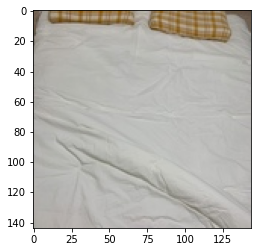

In [ ]:
#0번째 이미지 확인하기
plt.imshow(cv2.cvtColor(train_images[0], cv2.COLOR_BGR2RGB))

#### Zero-centering

In [ ]:
# zero-centering
compute_mean = lambda imgs : np.mean(imgs, axis=0)
mean_img = compute_mean(train_images)
mean_img.shape

(144, 144, 3)

In [ ]:
sub_mean_img = lambda image : image.astype('int8') - mean_img.astype('int8')
x_train = sub_mean_img(train_images)
x_test = sub_mean_img(test_images)
x_val = sub_mean_img(val_images)
x_real_test = sub_mean_img(real_test_images)
x_train.shape, x_test.shape, x_val.shape, x_real_test.shape

((28170, 144, 144, 3),
 (9423, 144, 144, 3),
 (9383, 144, 144, 3),
 (3, 144, 144, 3))

In [ ]:
with open('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/output/x_real_test.pickle', 'wb') as f3:
    pickle.dump(x_real_test, f3)

아래줄을 실행하기 전에 드라이브 마운트 필요

In [ ]:
#드라이브에 바로 저장- 이미지
with open('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/output/x_train.pickle', 'wb') as f1:
    pickle.dump(x_train, f1)
with open('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/output/x_test.pickle', 'wb') as f2:
    pickle.dump(x_test, f2)
with open('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/output/x_val.pickle', 'wb') as f3:
    pickle.dump(x_val, f3)

In [ ]:
#드라이브에 바로 저장- label
with open('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/output/train_labels.pickle', 'wb') as f1:
    pickle.dump(y_train, f1)
with open('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/output/test_labels.pickle', 'wb') as f2:
    pickle.dump(y_test, f2)
with open('/content/drive/MyDrive/이미지 분류 프로젝트(주은, 준석, 기훈)/output/val_labels.pickle', 'wb') as f3:
    pickle.dump(y_val, f3)